In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import auc, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import matthews_corrcoef, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
data = pd.read_csv("vscreenml_dude.csv")
data = data.sample(frac=1).reset_index(drop=True)
data = data.drop(["name", "PDB_code"], axis=1)

In [3]:
X = data.drop("Class", axis=1).values
y = data["Class"]

model = XGBClassifier(use_label_encoder=False)
skf = StratifiedKFold(n_splits=5)

prob_predictions = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train, eval_metric="logloss")
    
    df = pd.DataFrame(data.iloc[test_index,:])
    df["Proba"] = model.predict_proba(X_test)[:,1]
    
    prob_predictions.append(df)

prob_predictions = pd.concat(prob_predictions)


In [4]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X, y, eval_metric="logloss")
model.save_model('vscreenml_dude.json')

70 70


/Users/andriag/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


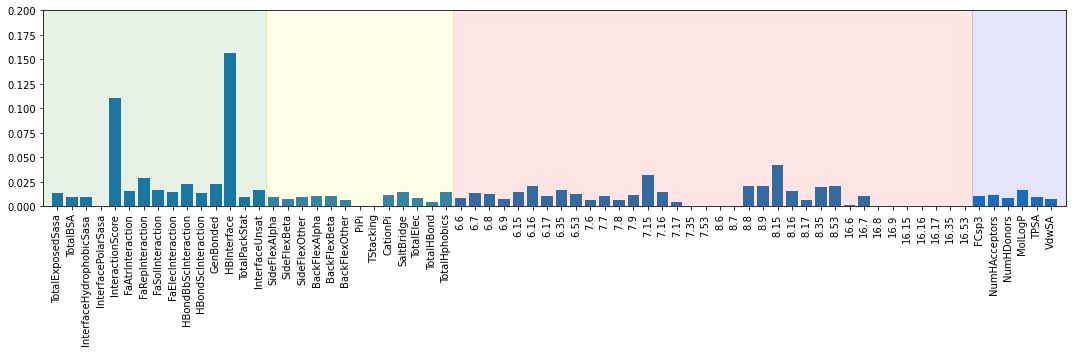

In [5]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

feature_importance = model.get_booster().get_score(importance_type='weight')

keys = data.columns[0:-1]
values = model.feature_importances_

print(len(keys), len(values))

ax.bar(keys, values)
ax.set_xticklabels(keys, rotation = 90);

ax.add_patch(Rectangle((-1.0, 0), 15.5, 1, color="green", alpha=0.1))
ax.add_patch(Rectangle((14.5, 0), 13.0, 1, color="yellow", alpha=0.1))
ax.add_patch(Rectangle((27.5, 0), 36.0, 1, color="red", alpha=0.1))
ax.add_patch(Rectangle((63.5, 0), 7.0, 1, color="blue", alpha=0.1))

ax.set_xlim(-1.0, len(keys));
ax.set_ylim(0.0, 0.2);

fig.tight_layout()
fig.savefig("FeatureImportance.png", dpi=150, facecolor="white")

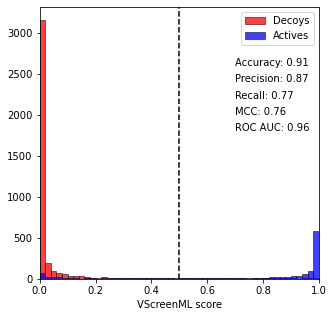

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.histplot(data=prob_predictions.query("Class == 0")["Proba"], binwidth=0.02, color="red")
sns.histplot(data=prob_predictions.query("Class == 1")["Proba"], binwidth=0.02, color="blue")

ax.legend(labels=["Decoys", "Actives"])
ax.set_ylabel("")
ax.set_xlabel("VScreenML score")

acc = accuracy_score(prob_predictions["Class"], round(prob_predictions["Proba"],0))
prc = precision_score(prob_predictions["Class"], round(prob_predictions["Proba"],0))
rec = recall_score(prob_predictions["Class"], round(prob_predictions["Proba"],0))
mcc = matthews_corrcoef(prob_predictions["Class"], round(prob_predictions["Proba"],0))
auc_score = roc_auc_score(prob_predictions["Class"], prob_predictions["Proba"])


ax.set_xlim(0,1)

ax.axvline(0.5, color="black", ls="--")
ax.text(0.7, 2600, f"Accuracy: {round(acc, 2)}")
ax.text(0.7, 2400, f"Precision: {round(prc, 2)}")
ax.text(0.7, 2200, f"Recall: {round(rec, 2)}")
ax.text(0.7, 2000, f"MCC: {round(mcc, 2)}")
ax.text(0.7, 1800, f"ROC AUC: {round(auc_score, 2)}")

fig.savefig("HistPredictions.png", dpi=150, facecolor="white")

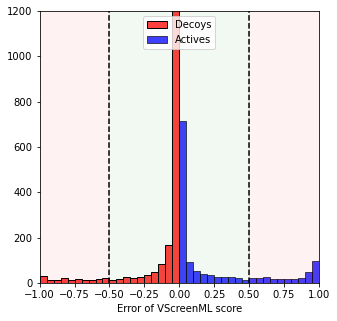

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.histplot(prob_predictions.query("Class == 0")[["Class", "Proba"]].apply(lambda x: x[0] - x[1], axis=1), binwidth=0.05, color="red")
sns.histplot(prob_predictions.query("Class == 1")[["Class", "Proba"]].apply(lambda x: x[0] - x[1], axis=1), binwidth=0.05, color="blue")

ax.legend(labels=["Decoys", "Actives"])
ax.set_ylabel("")
ax.set_xlabel("Error of VScreenML score")
ax.set_ylim(0,1200)
ax.set_xlim(-1,1)

ax.axvline(-0.5, color="black", ls="--")
ax.axvline(0.5, color="black", ls="--")

ax.add_patch(Rectangle((-0.5, 0), 1,  5000, color="green", alpha=0.05))
ax.add_patch(Rectangle((-1, 0),  0.5, 5000, color="red", alpha=0.05))
ax.add_patch(Rectangle((0.5, 0), 0.5, 5000, color="red", alpha=0.05))

fig.savefig("HistErrors.png", dpi=150, facecolor="white")

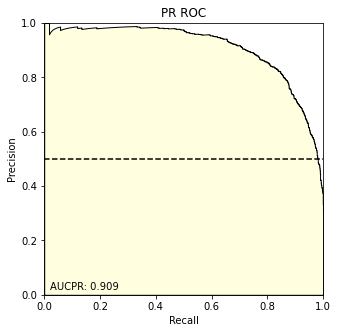

In [8]:
precision, recall, thresholds = precision_recall_curve(prob_predictions["Class"], prob_predictions["Proba"])
average_precision = auc(recall, precision)

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.fill_between(recall, precision, edgecolor="black", facecolor="lightyellow")
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.axhline(0.5, ls="--", color="black")

ax.set_title("PR ROC");
ax.text(0.02, 0.02, f"AUCPR: {round(average_precision, 3)}")

fig.savefig("AUCPR.png", dpi=150, facecolor="white")

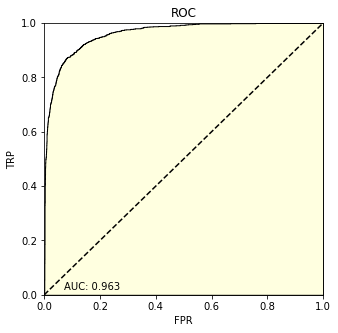

In [9]:
fpr, tpr, thresholds = roc_curve(prob_predictions["Class"], prob_predictions["Proba"])
auc_score = auc(fpr, tpr)

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.fill_between(fpr, tpr, edgecolor="black", facecolor="lightyellow")
ax.set_ylabel("TRP")
ax.set_xlabel("FPR")

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.plot([0,1], [0,1], ls="--", color="black")

ax.set_title("ROC");
ax.text(0.07, 0.02, f"AUC: {round(auc_score, 3)}")

fig.savefig("AUC.png", dpi=150, facecolor="white")

In [10]:
def extract_pdb_code(s):
    
    pdb_code = s.split("_")[1]
    lig_code = s.split("_chain")[1].split("_")[1]
    
    return pdb_code.upper() + "_" + lig_code

data = pd.read_csv("vscreenml_dude.csv")

rocs_scores = pd.read_csv("decoys_dude_rocs.csv")
rocs_scores["Name"] = rocs_scores["Name"].apply(lambda x: x[0:x.rfind("_")])
rocs_scores["ShapeQuery"] = rocs_scores["ShapeQuery"].apply(extract_pdb_code)

mcs_scores = pd.read_csv("decoys_dude_mcs.csv").drop("Active", axis=1)
mcs_scores.columns = ["Name", "MCSTanimoto"]

rocs_scores = rocs_scores.merge(mcs_scores, on="Name")
rocs_scores = rocs_scores[rocs_scores["ShapeQuery"].isin(data["PDB_code"])]

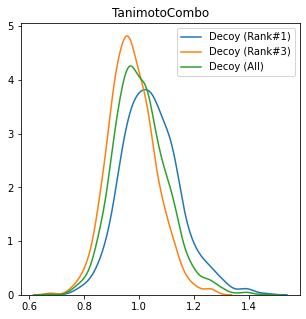

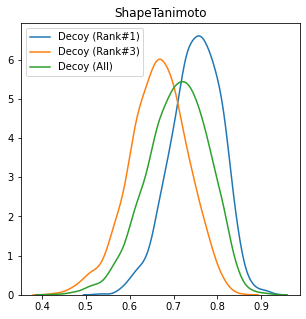

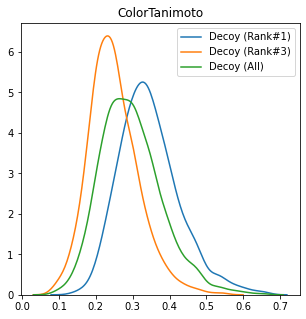

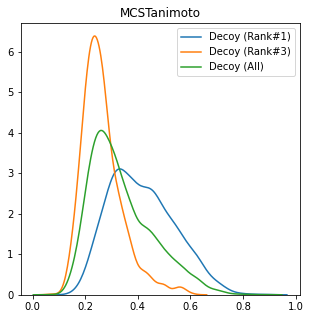

In [11]:
for c in ["TanimotoCombo", "ShapeTanimoto", "ColorTanimoto", "MCSTanimoto"]:

    fig, ax = plt.subplots(1,1, figsize=(5,5))
        
    sns.kdeplot(rocs_scores.groupby("ShapeQuery")[c].max(), ax=ax)
    sns.kdeplot(rocs_scores.groupby("ShapeQuery")[c].min(), ax=ax)
    sns.kdeplot(rocs_scores[c], ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(c)
    ax.legend(labels=["Decoy (Rank#1)", "Decoy (Rank#3)", "Decoy (All)"])
    
    fig.savefig(f"{c}.png", dpi=150, facecolor="white")